In [5]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

# Bounding Box Coordinate Conversions

In [6]:
def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.

    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.

    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

# Intersection over Union

In [7]:
def compute_iou(boxes1, boxes2):
    """Computes pairwise IOU matrix for given two sets of boxes

    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.

    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

# Calculating Anchors

In [8]:
class AnchorBox:
    """Generates anchor boxes.

    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.

    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level

        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.

        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.

        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.

        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

# Preprocessing 

In [9]:
def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance

    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.

    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
    return image, boxes


def resize_and_pad_image(
    image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
):
    """Resizes and pads image while preserving aspect ratio.

    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`

    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.

    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


def preprocess_data(sample):
    """Applies preprocessing step to a single sample

    Arguments:
      sample: A dict representing a single training sample.

    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

# Encoding Labels

In [10]:
class LabelEncoder:
    """Transforms the raw labels into targets for training.

    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.

    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        """Matches ground truth boxes to anchor boxes based on IOU.

        1. Calculates the pairwise IOU for the M `anchor_boxes` and N `gt_boxes`
          to get a `(M, N)` shaped matrix.
        2. The ground truth box with the maximum IOU in each row is assigned to
          the anchor box provided the IOU is greater than `match_iou`.
        3. If the maximum IOU in a row is less than `ignore_iou`, the anchor
          box is assigned with the background class.
        4. The remaining anchor boxes that do not have any class assigned are
          ignored during training.

        Arguments:
          anchor_boxes: A float tensor with the shape `(total_anchors, 4)`
            representing all the anchor boxes for a given input image shape,
            where each anchor box is of the format `[x, y, width, height]`.
          gt_boxes: A float tensor with shape `(num_objects, 4)` representing
            the ground truth boxes, where each box is of the format
            `[x, y, width, height]`.
          match_iou: A float value representing the minimum IOU threshold for
            determining if a ground truth box can be assigned to an anchor box.
          ignore_iou: A float value representing the IOU threshold under which
            an anchor box is assigned to the background class.

        Returns:
          matched_gt_idx: Index of the matched object
          positive_mask: A mask for anchor boxes that have been assigned ground
            truth boxes.
          ignore_mask: A mask for anchor boxes that need to by ignored during
            training
        """
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Creates box and classification targets for a single sample"""
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        """Creates box and classification targets for a batch"""
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

# Building backbone

In [11]:
def get_backbone():
    """Builds ResNet50 with pre-trained imagenet weights"""
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

# Building feature Pyramid Network

In [12]:
class FeaturePyramid(keras.layers.Layer):
    """Builds the Feature Pyramid with the feature maps from the backbone.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, backbone=None, **kwargs):
        super().__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

# Building classification and Box Regression Heads

In [13]:
def build_head(output_filters, bias_init):
    """Builds the class/box predictions head.

    Arguments:
      output_filters: Number of convolution filters in the final layer.
      bias_init: Bias Initializer for the final convolution layer.

    Returns:
      A keras sequential model representing either the classification
        or the box regression head depending on `output_filters`.
    """
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

# Building RetinaNet using Subclassed Model

In [14]:
class RetinaNet(keras.Model):
    """A subclassed Keras model implementing the RetinaNet architecture.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, num_classes, backbone=None, **kwargs):
        super().__init__(name="RetinaNet", **kwargs)
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

# Custom layer to decode predictions

In [15]:
class DecodePredictions(tf.keras.layers.Layer):
    """A Keras layer that decodes predictions of the RetinaNet model.

    Attributes:
      num_classes: Number of classes in the dataset
      confidence_threshold: Minimum class probability, below which detections
        are pruned.
      nms_iou_threshold: IOU threshold for the NMS operation
      max_detections_per_class: Maximum number of detections to retain per
       class.
      max_detections: Maximum number of detections to retain across all
        classes.
      box_variance: The scaling factors used to scale the bounding box
        predictions.
    """

    def __init__(
        self,
        num_classes=80,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

# Smooth L1 Loss and Focal Loss

In [16]:
class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super().__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma):
        super().__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super().__init__(reduction="sum", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

# Generating Data

In [2]:
import os
import random
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Constants
IMAGE_SIZE = 255
NUM_OBJECTS = 5
SYMBOL_FOLDER = "../data"  # Folder containing number and symbol images
OUTPUT_FOLDER = "generated_data"
ANNOTATION_FILE = "annotations.json"

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# Utility to load all symbol images
def load_symbol_images(folder):
    symbols = []
    labels = []
    for label in os.listdir(folder):
        class_folder = os.path.join(folder, label)
        if os.path.isdir(class_folder):
            for file in os.listdir(class_folder):
                file_path = os.path.join(class_folder, file)
                symbols.append(file_path)
                labels.append(label)
    return symbols, labels

# Check if two boxes overlap
def boxes_overlap(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    return not (x1_max < x2_min or x2_max < x1_min or y1_max < y2_min or y2_max < y1_min)

# Generate a random non-overlapping position
def get_non_overlapping_position(symbol_shape, placed_boxes):
    while True:
        x_min = random.randint(0, IMAGE_SIZE - symbol_shape[1])
        y_min = random.randint(0, IMAGE_SIZE - symbol_shape[0])
        x_max = x_min + symbol_shape[1]
        y_max = y_min + symbol_shape[0]
        new_box = [x_min, y_min, x_max, y_max]
        if all(not boxes_overlap(new_box, box) for box in placed_boxes):
            return new_box

def generate_image(symbols, labels, output_index):
    canvas = np.ones((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8) * 255
    placed_boxes = []
    annotations = {"image": f"image_{output_index}.png", "objects": []}

    for _ in range(NUM_OBJECTS):
        # Randomly choose a symbol and load it
        symbol_idx = random.randint(0, len(symbols) - 1)
        symbol_path = symbols[symbol_idx]
        label = labels[symbol_idx]
        symbol = cv2.imread(symbol_path, cv2.IMREAD_UNCHANGED)

        # Randomly resize the symbol
        scale = random.uniform(0.5, 1.0)
        new_width = int(symbol.shape[1] * scale)
        new_height = int(symbol.shape[0] * scale)
        symbol = cv2.resize(symbol, (new_width, new_height), interpolation=cv2.INTER_AREA)

        # Get non-overlapping position
        box = get_non_overlapping_position(symbol.shape, placed_boxes)
        placed_boxes.append(box)

        # Place the symbol on the canvas
        x_min, y_min, x_max, y_max = box
        if len(symbol.shape) == 3 and symbol.shape[-1] == 4:  # If symbol has alpha channel
            alpha = symbol[:, :, 3] / 255.0
            for c in range(3):  # Blend symbol with canvas
                canvas[y_min:y_max, x_min:x_max, c] = (
                    alpha * symbol[:, :, c] + (1 - alpha) * canvas[y_min:y_max, x_min:x_max, c]
                )
        else:  # If symbol is grayscale
            symbol_rgb = cv2.cvtColor(symbol, cv2.COLOR_GRAY2BGR) if len(symbol.shape) == 2 else symbol
            canvas[y_min:y_max, x_min:x_max] = symbol_rgb

        # Save annotation
        annotations["objects"].append({"class": label, "bbox": box})

    # Save the image and annotations
    image_path = os.path.join(OUTPUT_FOLDER, annotations["image"])
    cv2.imwrite(image_path, canvas)
    return annotations


# Generate the dataset
def generate_dataset(num_images=100):
    symbols, labels = load_symbol_images(SYMBOL_FOLDER)
    annotations_list = []

    for i in range(num_images):
        annotations = generate_image(symbols, labels, i)
        annotations_list.append(annotations)

    # Save annotations to a JSON file
    with open(os.path.join(OUTPUT_FOLDER, ANNOTATION_FILE), "w") as f:
        json.dump(annotations_list, f, indent=4)

# Generate 100 images with annotations
generate_dataset(100)


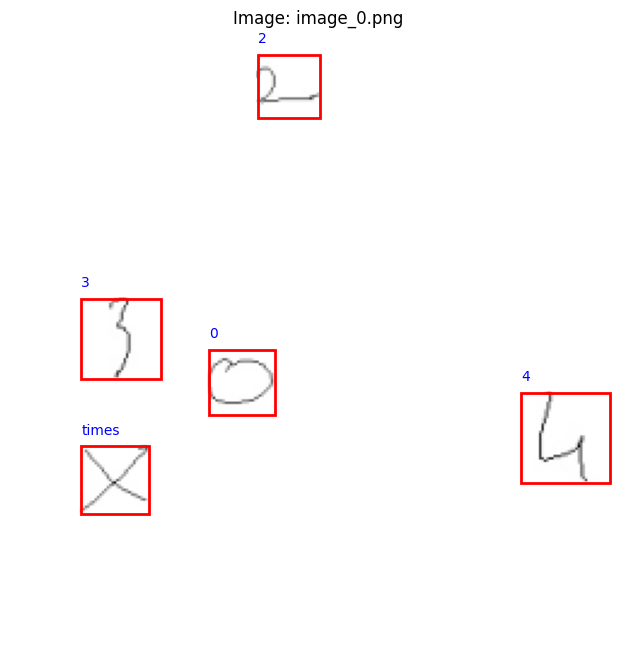

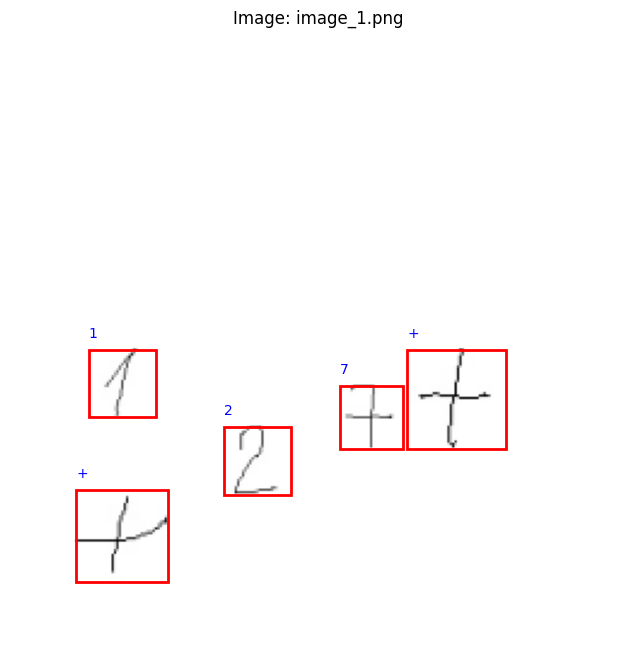

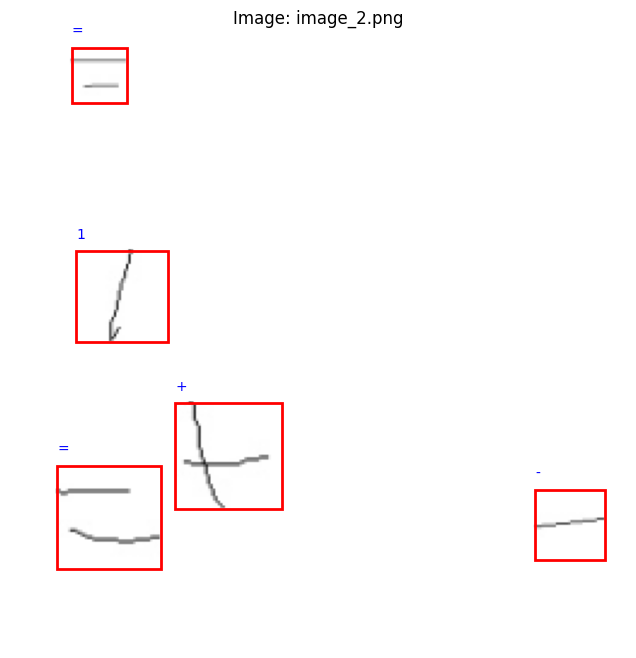

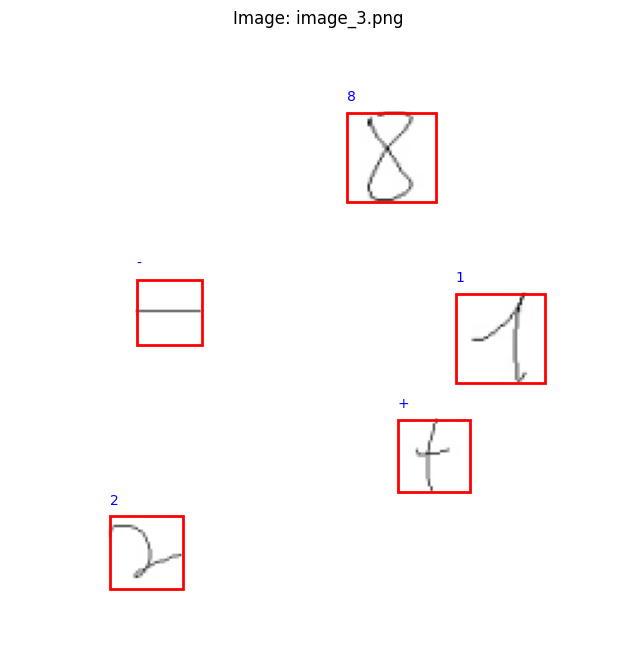

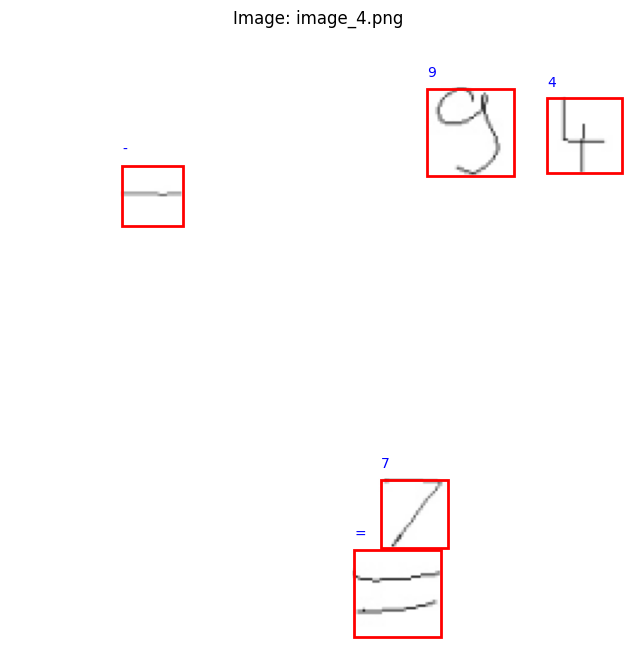

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import cv2
import os

# Path to generated data and annotations
OUTPUT_FOLDER = "generated_data"
ANNOTATION_FILE = "annotations.json"

# Load annotations
with open(os.path.join(OUTPUT_FOLDER, ANNOTATION_FILE), "r") as f:
    annotations_list = json.load(f)

# Function to visualize an image with bounding boxes
def visualize_image(index, annotations):
    annotation = annotations[index]
    image_path = os.path.join(OUTPUT_FOLDER, annotation["image"])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

    # Create a plot
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Image: {annotation['image']}")

    # Add bounding boxes
    for obj in annotation["objects"]:
        bbox = obj["bbox"]  # [xmin, ymin, xmax, ymax]
        label = obj["class"]
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        rect = patches.Rectangle(
            (bbox[0], bbox[1]),
            width,
            height,
            linewidth=2,
            edgecolor="red",
            facecolor="none",
        )
        ax.add_patch(rect)
        ax.text(
            bbox[0],
            bbox[1] - 5,
            label,
            color="blue",
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"),
        )

    plt.show()

# Visualize a few images
for i in range(5):  # Display first 5 images
    visualize_image(i, annotations_list)


# Preparing the Data

In [26]:
import tensorflow as tf

# Paths
OUTPUT_FOLDER = "generated_data"
ANNOTATION_FILE = "annotations.json"

# Load annotations
with open(os.path.join(OUTPUT_FOLDER, ANNOTATION_FILE), "r") as f:
    annotations_list = json.load(f)

# Function to parse image and annotations
def parse_data(annotation):
    image_path = os.path.join(OUTPUT_FOLDER, annotation["image"])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)  # Normalize to [0, 1]

    bboxes = tf.constant([obj["bbox"] for obj in annotation["objects"]], dtype=tf.float32)
    class_ids = tf.constant([int(obj["class"]) for obj in annotation["objects"]], dtype=tf.int32)

    return {"image": image, "objects": {"bbox": bboxes, "label": class_ids}}

# Create TensorFlow dataset
def create_tf_dataset(annotations, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: (parse_data(ann) for ann in annotations),
        output_signature={
            "image": tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),
            "objects": {
                "bbox": tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                "label": tf.TensorSpec(shape=(None,), dtype=tf.int32),
            },
        },
    )

    autotune = tf.data.AUTOTUNE
    dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
    dataset = dataset.shuffle(8 * batch_size)
    dataset = dataset.padded_batch(
        batch_size=batch_size,
        padding_values=(0.0, 1e-8, -1),  # Padding for image, bbox, and label
        drop_remainder=True,
    )
    
    # Pass `gt_boxes` and `cls_ids` explicitly to `encode_batch`
    def map_label_encoder(data):
        # Extract required elements from the dictionary
        images = data["image"]
        gt_boxes = data["objects"]["bbox"]
        cls_ids = data["objects"]["label"]
    
        # Add batch dimension (encode_batch expects batched inputs)
        batch_images = tf.expand_dims(images, axis=0)  # Shape: (1, height, width, channels)
        batch_gt_boxes = tf.expand_dims(gt_boxes, axis=0)  # Shape: (1, num_boxes, 4)
        batch_cls_ids = tf.expand_dims(cls_ids, axis=0)  # Shape: (1, num_boxes)
    
        # Use the label encoder to process this data
        encoded_images, encoded_labels = label_encoder.encode_batch(
            batch_images, batch_gt_boxes, batch_cls_ids
        )
    
        # Remove the batch dimension for consistency
        return encoded_images[0], encoded_labels[0]



    dataset = dataset.map(map_label_encoder, num_parallel_calls=autotune)
    dataset = dataset.prefetch(autotune)
    return dataset


train_dataset = train_dataset.map(
    map_label_encoder, num_parallel_calls=tf.data.AUTOTUNE
)
val_dataset = val_dataset.map(
    map_label_encoder, num_parallel_calls=tf.data.AUTOTUNE
)



NameError: name 'train_dataset' is not defined

In [27]:
import tensorflow as tf
import numpy as np
import json
from PIL import Image

# Path to dataset
images_folder = "generated_data"
annotations_file = "generated_data/annotations.json"

# Load annotations
with open(annotations_file, "r") as f:
    annotations = json.load(f)

def load_image_and_annotations(entry):
    # Load image
    image_path = tf.strings.join([images_folder, entry["image"]], separator="/")
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Parse annotations
    bboxes = entry["objects"]
    boxes = tf.convert_to_tensor([obj["bbox"] for obj in bboxes], dtype=tf.float32)
    labels = tf.convert_to_tensor([obj["label"] for obj in bboxes], dtype=tf.int32)

    return {"image": image, "objects": {"bbox": boxes, "label": labels}}

def preprocess_dataset(annotations):
    # Create dataset
    dataset = tf.data.Dataset.from_generator(
        lambda: (load_image_and_annotations(entry) for entry in annotations),
        output_signature={
            "image": tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),
            "objects": {
                "bbox": tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                "label": tf.TensorSpec(shape=(None,), dtype=tf.int32),
            },
        },
    )
    return dataset


In [28]:
# Split into training and validation sets (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(annotations))
train_annotations = annotations[:train_size]
val_annotations = annotations[train_size:]

# Create datasets
train_dataset = preprocess_dataset(train_annotations)
val_dataset = preprocess_dataset(val_annotations)


In [29]:
# Apply preprocessing
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)


In [30]:
batch_size = 4  # Adjust based on system capability
padding_values = (0.0, 1e-8, -1)  # Padding for image, bbox, and labels

train_dataset = train_dataset.padded_batch(
    batch_size=batch_size,
    padding_values=padding_values,  # Padding for each part of the data
    drop_remainder=True,
)
val_dataset = val_dataset.padded_batch(
    batch_size=batch_size,
    padding_values=padding_values,
    drop_remainder=True,
)


In [31]:
label_encoder = LabelEncoder()

def encode_batch(batch):
    images = batch["image"]
    bboxes = batch["objects"]["bbox"]
    labels = batch["objects"]["label"]
    return label_encoder.encode_batch(images, bboxes, labels)

train_dataset = train_dataset.map(encode_batch, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(encode_batch, num_parallel_calls=tf.data.AUTOTUNE)


TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__encode_batch() takes 1 positional argument but 3 were given
